In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p
import numpy as np
import os 

In [43]:
df_train_house_prices = pd.read_csv('/home/shashank/workspace/datascience/assignment/datavisualization/house-prices-advanced-regression-techniques/train.csv')
df_test_house_prices = pd.read_csv('/home/shashank/workspace/datascience/assignment/datavisualization/house-prices-advanced-regression-techniques/train.csv')

df_train_titanic_prices = pd.read_csv('/home/shashank/workspace/datascience/assignment/datavisualization/data_visualization/titanic/train.csv')
df_test_titanic_prices = pd.read_csv('/home/shashank/workspace/datascience/assignment/datavisualization/data_visualization/titanic/test.csv')


In [61]:
ntrain = df_train_house_prices.shape[0]
ntest = df_test_house_prices.shape[0]
y_train = df_train_house_prices.SalePrice.values
all_data = pd.concat((df_train_house_prices, df_test_house_prices)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2920, 81)


# Histogram

## Normality - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

## Homoscedasticity - I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Predictor variable is the name given to an independent variable used in regression analyses. Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

## Linearity- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

## Absence of correlated errors - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

# If skewness is less than -1 or greater than 1, the distribution is highly skewed.

# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.

# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

# Kurtosis tells you the height and sharpness of the central peak, relative to that of a standard bell curve.



Skewness: 1.882876
Kurtosis: 6.536282


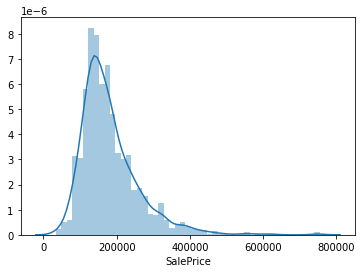

In [44]:
sns.distplot(df_train_house_prices['SalePrice']);
print("Skewness: %f" % df_train_house_prices['SalePrice'].skew())
print("Kurtosis: %f" % df_train_house_prices['SalePrice'].kurt())

# In the search for normality

## The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:

## Histogram - Kurtosis and skewness.

## Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.


 mu = 180921.20 and sigma = 79415.29



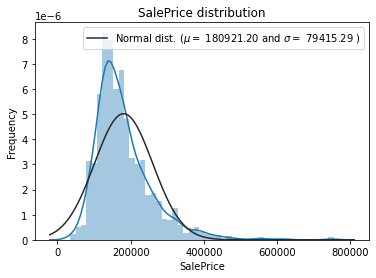

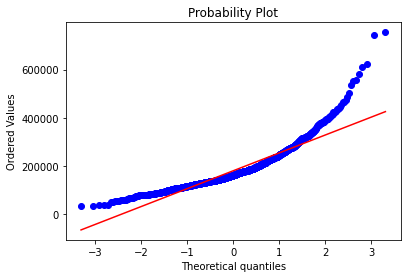

In [45]:
sns.distplot(df_train_house_prices['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train_house_prices['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train_house_prices['SalePrice'], plot=plt)
plt.show()

## Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

## The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

## In case of positive skewness, log transformations usually works well.

In [46]:
#applying log transformation
df_train_house_prices['SalePrice'] = np.log(df_train_house_prices['SalePrice'])


 mu = 12.02 and sigma = 0.40



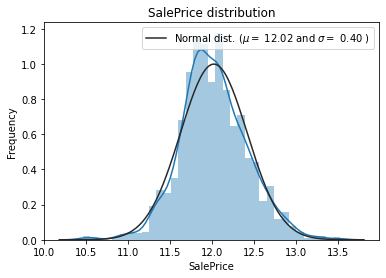

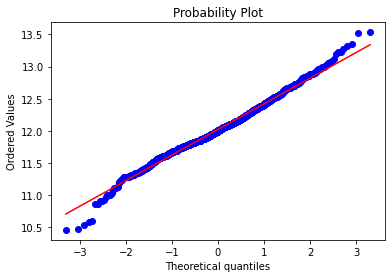

In [47]:
#transformed histogram and normal probability plot
sns.distplot(df_train_house_prices['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train_house_prices['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train_house_prices['SalePrice'], plot=plt)
plt.show()

# Do This All Remaining Column Which Are Not Normal

## A significant number of observations with value zero (houses without basement). A big problem because the value zero doesn't allow us to do log transformations.

## To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

## I'm not sure if this approach is correct. It just seemed right to me. That's what I call 'high risk engineering'.

In [48]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train_house_prices['HasBsmt'] = pd.Series(len(df_train_house_prices['TotalBsmtSF']), index=df_train_house_prices.index)
df_train_house_prices['HasBsmt'] = 0 
df_train_house_prices.loc[df_train_house_prices['TotalBsmtSF']>0,'HasBsmt'] = 1

In [49]:
#transform data
df_train_house_prices.loc[df_train_house_prices['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train_house_prices['TotalBsmtSF'])

/home/shashank/workspace/datascience/assignment/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


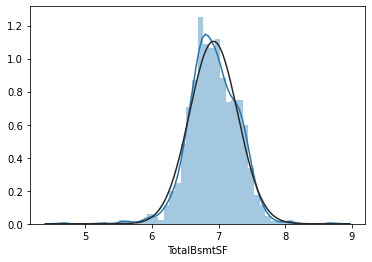

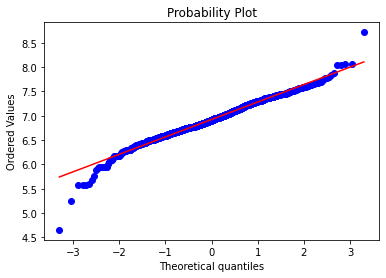

In [50]:
#histogram and normal probability plot
sns.distplot(df_train_house_prices[df_train_house_prices['TotalBsmtSF']>0]['TotalBsmtSF'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train_house_prices[df_train_house_prices['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

## Homoscedasticity - I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

## The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

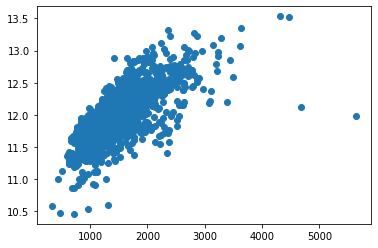

In [51]:
plt.scatter(df_train_house_prices['GrLivArea'], df_train_house_prices['SalePrice']);

# other method of transformation is Box Cox Transformation for (highly) skewed features 

# we can use log transformation for target feature and boxcox transformation for independent features

# 

In [62]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
MiscVal        24.451640
PoolArea       14.813135
LotArea        12.195142
3SsnPorch      10.293752
LowQualFinSF    9.002080
KitchenAbvGr    4.483784
BsmtFinSF2      4.250888
ScreenPorch     4.117977
BsmtHalfBath    4.099186
EnclosedPorch   3.086696

In [68]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 38 skewed numerical features to Box Cox transform


In [69]:
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [70]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
PoolArea       14.342868
3SsnPorch       7.669694
LowQualFinSF    7.374240
MiscVal         5.082645
BsmtHalfBath    3.898693
KitchenAbvGr    3.339055
ScreenPorch     3.128072
BsmtFinSF2      2.472925
EnclosedPorch   2.078729
HalfBath        0.545949

# Correlating numerical features

## # A histogram chart is useful for analyzing continous numerical variables like Age

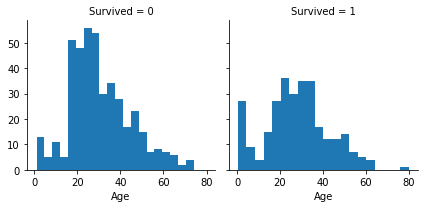

In [52]:

g = sns.FacetGrid(df_train_titanic_prices, col='Survived')
g.map(plt.hist, 'Age', bins=20)

## #Correlating numerical and ordinal features

/home/shashank/workspace/datascience/assignment/env/lib/python3.6/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


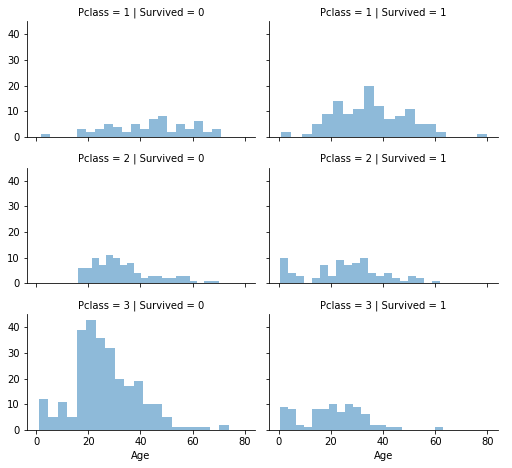

In [53]:
grid = sns.FacetGrid(df_train_titanic_prices, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## # Correlating categorical features

/home/shashank/workspace/datascience/assignment/env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/shashank/workspace/datascience/assignment/env/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


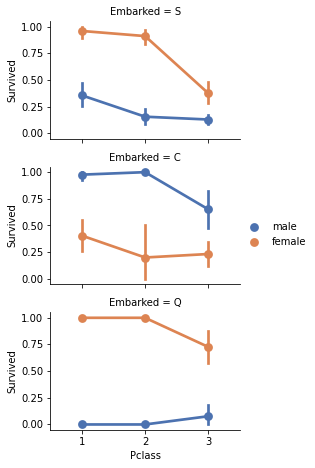

In [54]:
grid = sns.FacetGrid(df_train_titanic_prices, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

## # Correlating categorical and numerical features

We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric).

/home/shashank/workspace/datascience/assignment/env/lib/python3.6/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/shashank/workspace/datascience/assignment/env/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


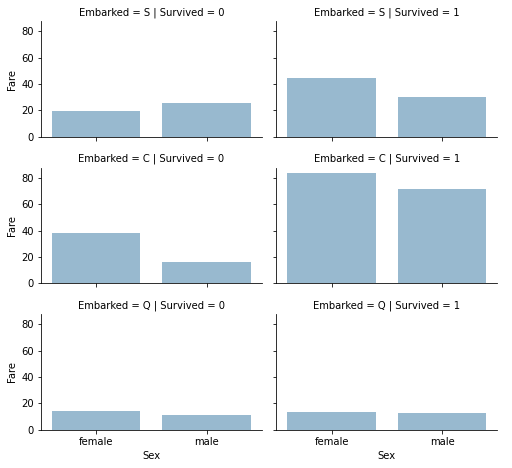

In [55]:
grid = sns.FacetGrid(df_train_titanic_prices, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

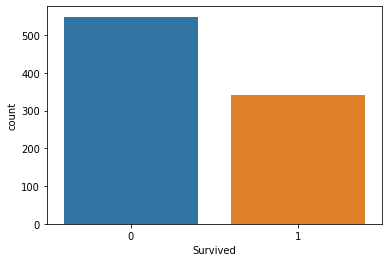

In [71]:
# plotting categorical feature

g = sns.countplot(df_train_titanic_prices['Survived'])

# scatter plot 


## # We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers. Therefore, we can safely delete them.

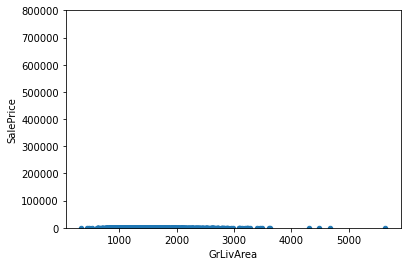

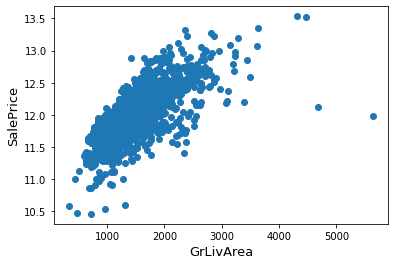

In [56]:
var = 'GrLivArea'
data = pd.concat([df_train_house_prices['SalePrice'], df_train_house_prices[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# or

fig, ax = plt.subplots()
ax.scatter(x = df_train_house_prices['GrLivArea'], y = df_train_house_prices['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# BAR PLOT

## Missing Data (Bar plot can used to check missing data in dataframe)

In [59]:


all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

all_data size is : (2920, 81)


Missing Ratio
PoolQC            99.520548
MiscFeature       96.301370
Alley             93.767123
Fence             80.753425
HasBsmt           50.000000
FireplaceQu       47.260274
LotFrontage       17.739726
GarageYrBlt        5.547945
GarageType         5.547945
GarageFinish       5.547945
GarageQual         5.547945
GarageCond         5.547945
BsmtFinType2       2.602740
BsmtExposure       2.602740
BsmtFinType1       2.534247
BsmtCond           2.534247
BsmtQual           2.534247
MasVnrArea         0.547945
MasVnrType         0.547945
Electrical         0.068493

Text(0.5, 1.0, 'Percent missing data by feature')

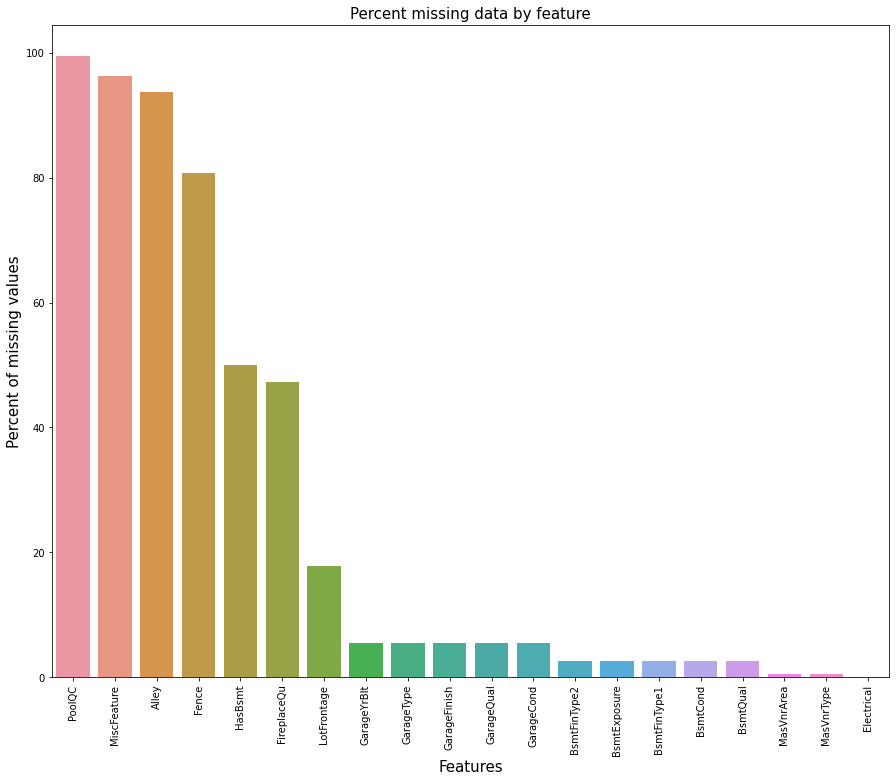

In [60]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# box plot

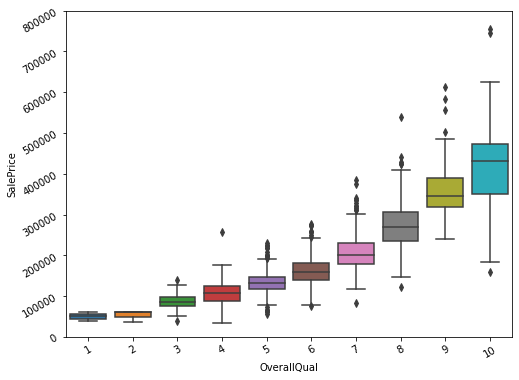

In [24]:
var = 'OverallQual'
data = pd.concat([df_train_house_prices['SalePrice'], df_train_house_prices[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=30);
plt.yticks(rotation=30);

# Pairplots

## # Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.

/home/shashank/workspace/datascience/assignment/env/lib/python3.6/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


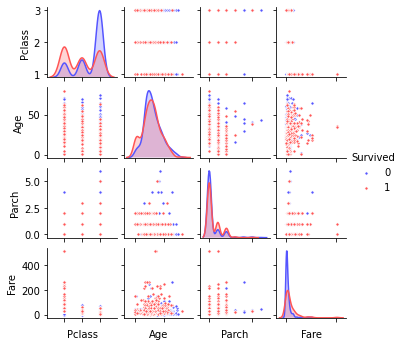

In [79]:
g = sns.pairplot(df_train_titanic_prices[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# correlation matrix

## # Pearson Correlation Heatmap
### # let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

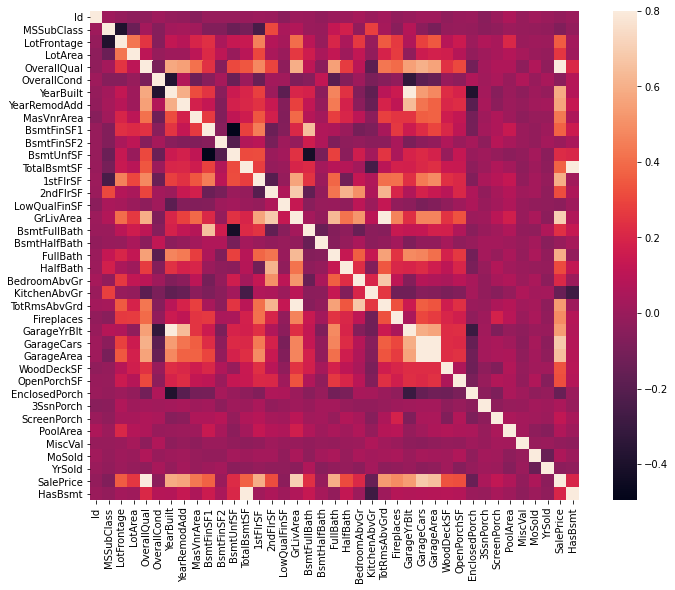

In [74]:
corrmat = df_train_house_prices.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);



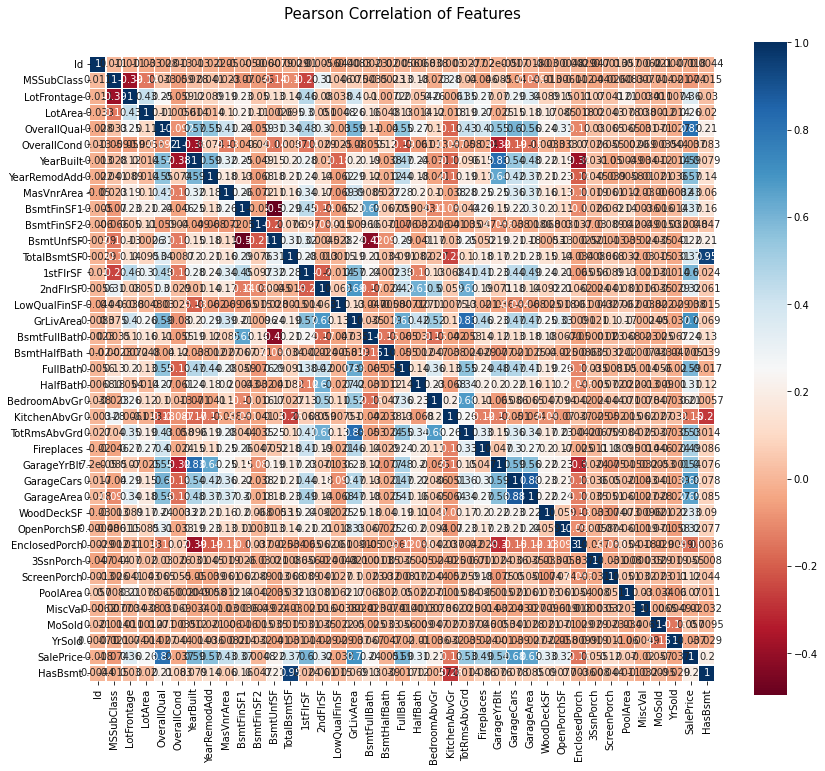

In [75]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_train_house_prices.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

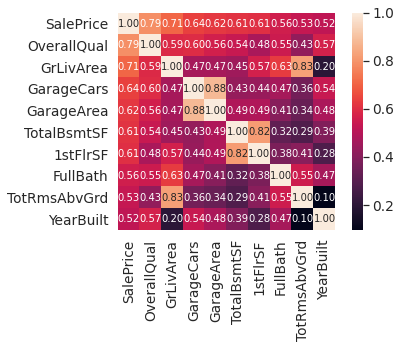

In [26]:
# Finding out those 10 variable which are highly correlated with target outcome  
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train_house_prices[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train_house_prices[cols], size = 2.5)
plt.show();